## Prepare Dataset

### Flow count for VPN and non-VPN

label
NoVPN    43597
VPN       8350
Name: count, dtype: int64


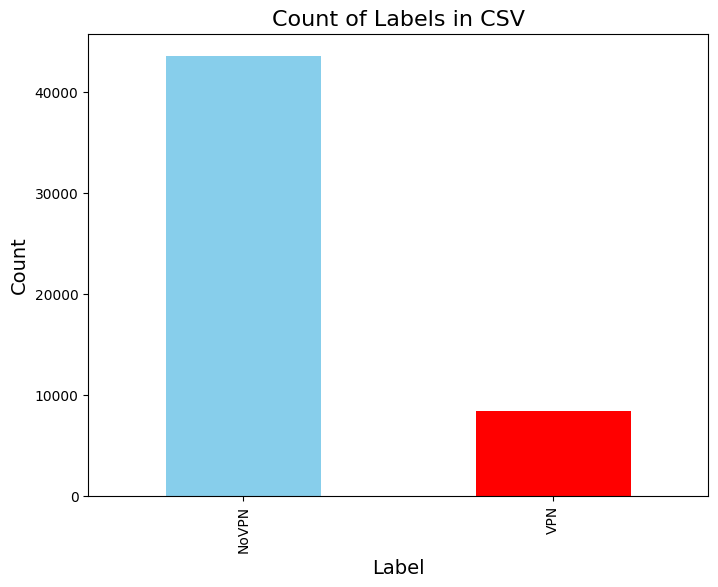

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./VNAT/WF/flows_extra_labelled_12.csv',low_memory=False)

label_counts = df['label'].value_counts()
print(label_counts)

plt.figure(figsize=(8, 6))  
label_counts.plot(kind='bar', color=['skyblue', 'red'])

plt.title('Count of Labels in CSV', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()


### Create a dataset for Statistical Features

In [3]:
import pandas as pd
import numpy as np

df1 = pd.read_csv('./VNAT/WF/flows_extra_labelled_12.csv',low_memory=False)

columns_to_select = [
                    'src2dst_mean_ps','src2dst_min_ps', 'src2dst_max_ps','src2dst_stddev_ps',
                    'dst2src_mean_ps','dst2src_min_ps','dst2src_max_ps','dst2src_stddev_ps',
                    'bidirectional_mean_ps','bidirectional_min_ps','bidirectional_max_ps','bidirectional_stddev_ps',
                    'src2dst_mean_piat_ms','src2dst_min_piat_ms', 'src2dst_max_piat_ms','src2dst_stddev_piat_ms',
                    'dst2src_mean_piat_ms','dst2src_min_piat_ms','dst2src_max_piat_ms','dst2src_stddev_piat_ms',
                    'bidirectional_mean_piat_ms','bidirectional_min_piat_ms','bidirectional_max_piat_ms','bidirectional_stddev_piat_ms'
                   , 'label','category']
df_WNF = df1[columns_to_select]                  

df_WNF.to_csv('./VNAT/WF/flows_extra_labelled_SF.csv', index=False)

### Rndom Forest

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

output_dir = "SF_results"
os.makedirs(output_dir, exist_ok=True)

file_path = './VNAT/WF/flows_extra_labelled_SF.csv'
df = pd.read_csv(file_path)

df['label_encoded'] = df['label'].map({'NoVPN': 0, 'VPN': 1})

category = df['category']

X = df.drop(['label', 'label_encoded', 'category'], axis=1)
y = df['label_encoded']

X_train, X_test, y_train, y_test, category_train, category_test = train_test_split(
    X, y, category, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, normalize='true')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['NoVPN', 'VPN'], yticklabels=['NoVPN', 'VPN'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
conf_matrix_path = os.path.join(output_dir, "confusion_matrix_RF_SF.png")
plt.savefig(conf_matrix_path)
plt.close()

accuracy_report_path = os.path.join(output_dir, "accuracy_classification_report_RF_SF.txt")
with open(accuracy_report_path, "w") as f:
    f.write(f"Train Accuracy: {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

misclassified_mask = (y_test != y_pred)
misclassified_samples = X_test.loc[misclassified_mask].copy()

misclassified_samples['true_label'] = y_test.loc[misclassified_mask]
misclassified_samples['predicted_label'] = y_pred[misclassified_mask]
misclassified_samples['category'] = category_test.loc[misclassified_mask]

label_map = {0: 'NoVPN', 1: 'VPN'}
misclassified_samples['true_label'] = misclassified_samples['true_label'].map(label_map)
misclassified_samples['predicted_label'] = misclassified_samples['predicted_label'].map(label_map)

misclassification_detail = misclassified_samples.groupby(['category', 'true_label', 'predicted_label']).size().reset_index(name='count')

print("\nDetailed Misclassification Summary (per Category):")
print(misclassification_detail)

misclassification_detail_path = os.path.join(output_dir, "detailed_misclassification_summary_RF_SF.csv")
misclassification_detail.to_csv(misclassification_detail_path, index=False)

print("Confusion matrix saved at:", conf_matrix_path)
print("Accuracy and classification report saved at:", accuracy_report_path)
print("Detailed misclassification summary saved at:", misclassification_detail_path)


Train Accuracy: 0.999975936665303
Test Accuracy: 1.0

Confusion Matrix:
[[1. 0.]
 [0. 1.]]

Classification Report:
              precision    recall  f1-score   support

       NoVPN       1.00      1.00      1.00      8721
         VPN       1.00      1.00      1.00      1669

    accuracy                           1.00     10390
   macro avg       1.00      1.00      1.00     10390
weighted avg       1.00      1.00      1.00     10390


Detailed Misclassification Summary (per Category):
Empty DataFrame
Columns: [category, true_label, predicted_label, count]
Index: []
Confusion matrix saved at: SF_results\confusion_matrix_RF_SF.png
Accuracy and classification report saved at: SF_results\accuracy_classification_report_RF_SF.txt
Detailed misclassification summary saved at: SF_results\detailed_misclassification_summary_RF_SF.csv


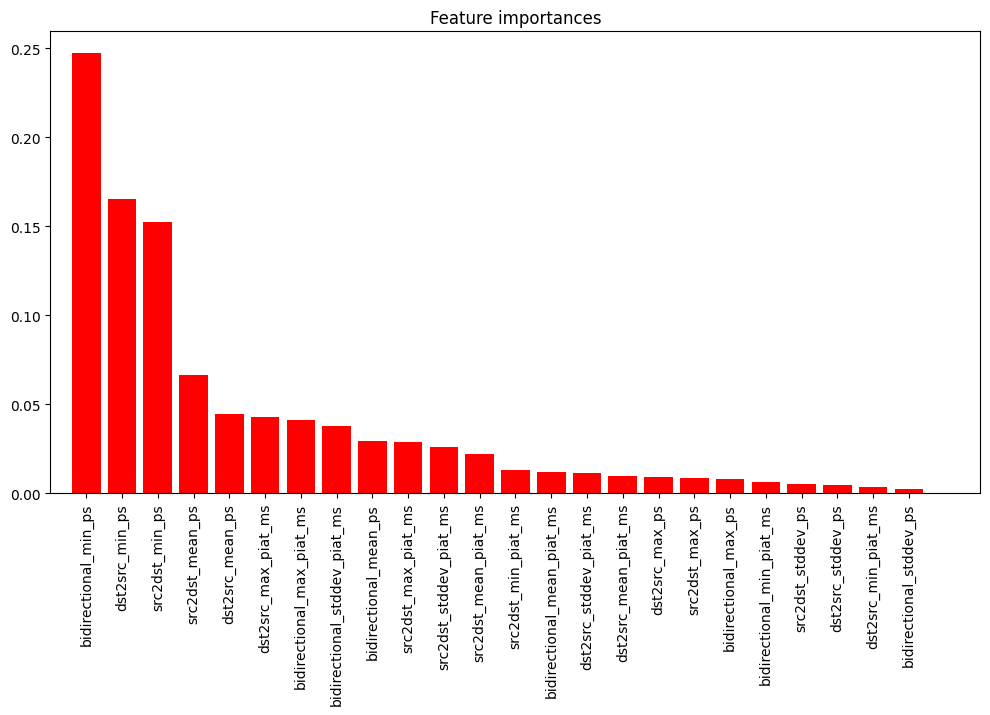

In [6]:
#feature importances
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]+1])
plt.show()

### SVM

In [9]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

output_dir = "SF_results"
os.makedirs(output_dir, exist_ok=True)

file_path = './VNAT/WF/flows_extra_labelled_SF.csv' 
df = pd.read_csv(file_path)

df['label_encoded'] = df['label'].map({'NoVPN': 0, 'VPN': 1})

category = df['category']

X = df.drop(['label', 'label_encoded', 'category'], axis=1)
y = df['label_encoded']

X_train, X_test, y_train, y_test, category_train, category_test = train_test_split(
    X, y, category, test_size=0.2, random_state=42
)

clf = LinearSVC(random_state=42, max_iter=10000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

train_accuracy = accuracy_score(y_train, clf.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, normalize='true')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['NoVPN', 'VPN'], yticklabels=['NoVPN', 'VPN'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
conf_matrix_path = os.path.join(output_dir, "confusion_matrix_SVM_SF.png")
plt.savefig(conf_matrix_path)
plt.close()

accuracy_report_path = os.path.join(output_dir, "accuracy_classification_report_SVM_SF.txt")
with open(accuracy_report_path, "w") as f:
    f.write(f"Train Accuracy: {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

misclassified_mask = (y_test != y_pred)
misclassified_samples = X_test.loc[misclassified_mask].copy()

misclassified_samples['true_label'] = y_test.loc[misclassified_mask]
misclassified_samples['predicted_label'] = y_pred[misclassified_mask]
misclassified_samples['category'] = category_test.loc[misclassified_mask]

label_map = {0: 'NoVPN', 1: 'VPN'}
misclassified_samples['true_label'] = misclassified_samples['true_label'].map(label_map)
misclassified_samples['predicted_label'] = misclassified_samples['predicted_label'].map(label_map)

misclassification_detail = misclassified_samples.groupby(['category', 'true_label', 'predicted_label']).size().reset_index(name='count')

print("\nDetailed Misclassification Summary (per Category):")
print(misclassification_detail)

misclassification_detail_path = os.path.join(output_dir, "detailed_misclassification_summary_SVM_SF.csv")
misclassification_detail.to_csv(misclassification_detail_path, index=False)

print("Confusion matrix saved at:", conf_matrix_path)
print("Accuracy and classification report saved at:", accuracy_report_path)
print("Detailed misclassification summary saved at:", misclassification_detail_path)


Train Accuracy: 0.9766104386745915
Test Accuracy: 0.9790182868142445

Confusion Matrix:
[[0.98784543 0.01215457]
 [0.06710605 0.93289395]]

Classification Report:
              precision    recall  f1-score   support

       NoVPN       0.99      0.99      0.99      8721
         VPN       0.94      0.93      0.93      1669

    accuracy                           0.98     10390
   macro avg       0.96      0.96      0.96     10390
weighted avg       0.98      0.98      0.98     10390


Detailed Misclassification Summary (per Category):
            category true_label predicted_label  count
0               Chat      NoVPN             VPN      6
1               Chat        VPN           NoVPN     11
2  Command & Control      NoVPN             VPN      4
3  Command & Control        VPN           NoVPN     16
4      File Transfer      NoVPN             VPN     49
5      File Transfer        VPN           NoVPN      8
6          Streaming      NoVPN             VPN      9
7          Streami

### Neural Network

In [16]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow import keras

output_dir = "SF_results"
os.makedirs(output_dir, exist_ok=True)

file_path = './VNAT/WF/flows_extra_labelled_SF.csv' 
df = pd.read_csv(file_path)

df['label_encoded'] = df['label'].map({'NoVPN': 0, 'VPN': 1})

category = df['category']

X = df.drop(['label', 'label_encoded', 'category'], axis=1)
y = df['label_encoded']

X_train, X_test, y_train, y_test, category_train, category_test = train_test_split(
    X, y, category, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

train_accuracy = model.evaluate(X_train, y_train, verbose=0)[1]
test_accuracy = accuracy_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred, normalize='true')

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=['NoVPN', 'VPN'], yticklabels=['NoVPN', 'VPN'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
conf_matrix_path = os.path.join(output_dir, "confusion_matrix_NN_SF.png")
plt.savefig(conf_matrix_path)
plt.close()

accuracy_report_path = os.path.join(output_dir, "accuracy_classification_report_NN_SF.txt")
with open(accuracy_report_path, "w") as f:
    f.write(f"Train Accuracy: {train_accuracy:.4f}\n")
    f.write(f"Test Accuracy: {test_accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(classification_report(y_test, y_pred, target_names=['NoVPN', 'VPN']))

misclassified_mask = (y_test != y_pred)
misclassified_samples = X_test[misclassified_mask]

misclassified_samples = pd.DataFrame(misclassified_samples, columns=X.columns)
misclassified_samples['true_label'] = y_test.loc[misclassified_mask].values
misclassified_samples['predicted_label'] = y_pred[misclassified_mask]
misclassified_samples['category'] = category_test.loc[misclassified_mask].values

label_map = {0: 'NoVPN', 1: 'VPN'}
misclassified_samples['true_label'] = misclassified_samples['true_label'].map(label_map)
misclassified_samples['predicted_label'] = misclassified_samples['predicted_label'].map(label_map)

misclassification_detail = misclassified_samples.groupby(['category', 'true_label', 'predicted_label']).size().reset_index(name='count')

print("\nDetailed Misclassification Summary (per Category):")
print(misclassification_detail)

misclassification_detail_path = os.path.join(output_dir, "detailed_misclassification_summary_NN_SF.csv")
misclassification_detail.to_csv(misclassification_detail_path, index=False)

print("Confusion matrix saved at:", conf_matrix_path)
print("Accuracy and classification report saved at:", accuracy_report_path)
print("Detailed misclassification summary saved at:", misclassification_detail_path)


Epoch 1/20


C:\Users\yasah\anaconda3\envs\py311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1299/1299 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.9701 - loss: 0.0845 - val_accuracy: 0.9989 - val_loss: 0.0085
Epoch 2/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9990 - loss: 0.0054 - val_accuracy: 0.9990 - val_loss: 0.0054
Epoch 3/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9993 - loss: 0.0037 - val_accuracy: 0.9990 - val_loss: 0.0044
Epoch 4/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9994 - loss: 0.0023 - val_accuracy: 0.9991 - val_loss: 0.0036
Epoch 5/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9993 - loss: 0.0024 - val_accuracy: 0.9992 - val_loss: 0.0022
Epoch 6/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9996 - loss: 0.0012 - val_accuracy: 0.9993 - val_loss: 0.0022
Epoch 7/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9991 - val_loss: 0.0028
Epoch 8/20
1299/1299 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9997 - loss: 7.6117e-04 - val